In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pareto
from scipy.stats import gamma as gamma_dist

from funcs import (
    moment_magnitude,
    seismic_moment,
    plot_distr,
    pdf_naive,
    cdf_naive,
    cdf_corr_naive,
    pdf_unbiased,
    cdf_unbiased,
    pdf_jeffreys,
    cdf_jeffreys,
    mean_var_from_cdf,
    summary_naive,
    summary_corrected_naive,
    summary_jeffreys,
    summary_unbiased,
    gamma_pdf,
    norm_pdf,
    E_all,
    get_var_naive,
    get_var_corrected_naive,
    get_var_jeffreys,
    get_var_unbiased
)


We draw catalogues with varying $n$ and $b^{*}_{true}$ and calculate $T=\sum\limits_{i=1}^n {M_i-m_0}$  
We then verify that $T \sim \mathrm{Gamma}(n,rate=b^{*}_{true})$ (or, as implemented in numpy and scipy: $T \sim \mathrm{Gamma}(n,scale=1/b^{*}_{true})$)


In [2]:
mag_completeness = 0.0
moment_completeness = seismic_moment(mag_completeness)

recalculate = False # Set to True to redo simulations
if recalculate:
    # Simulation parameters
    nr_simulations = 100_000 # Per setup. We'll be running different ground truth parameters and different catalogue sizes
    b_true_range = np.array([0.6, 0.8, 1.0, 1.2, 1.4])
    cat_sizes = np.array([50 ,100, 1000, 10000])

    t_all = np.zeros((len(b_true_range), len(cat_sizes), nr_simulations))
    for i, b_true in enumerate(b_true_range):
        for j, n in enumerate(cat_sizes):
            gt_dist = pareto((2/3)*b_true, scale=seismic_moment(mag_completeness), loc=0)
            for k in range(nr_simulations):
                # Generate catalogue
                cat = moment_magnitude(gt_dist.rvs(n))
                # Save the sufficient statistic S = sum of magnitudes
                t_all[i,j,k]= np.sum(cat)
            
    np.savez("cat_simulations.npz",
        b_true_range=b_true_range,
        cat_sizes=cat_sizes,
        s_all=t_all,
        )
else:    
    data = np.load("cat_simulations.npz")
    b_true_range = data["b_true_range"]
    cat_sizes = data["cat_sizes"]
    t_all = data["s_all"]

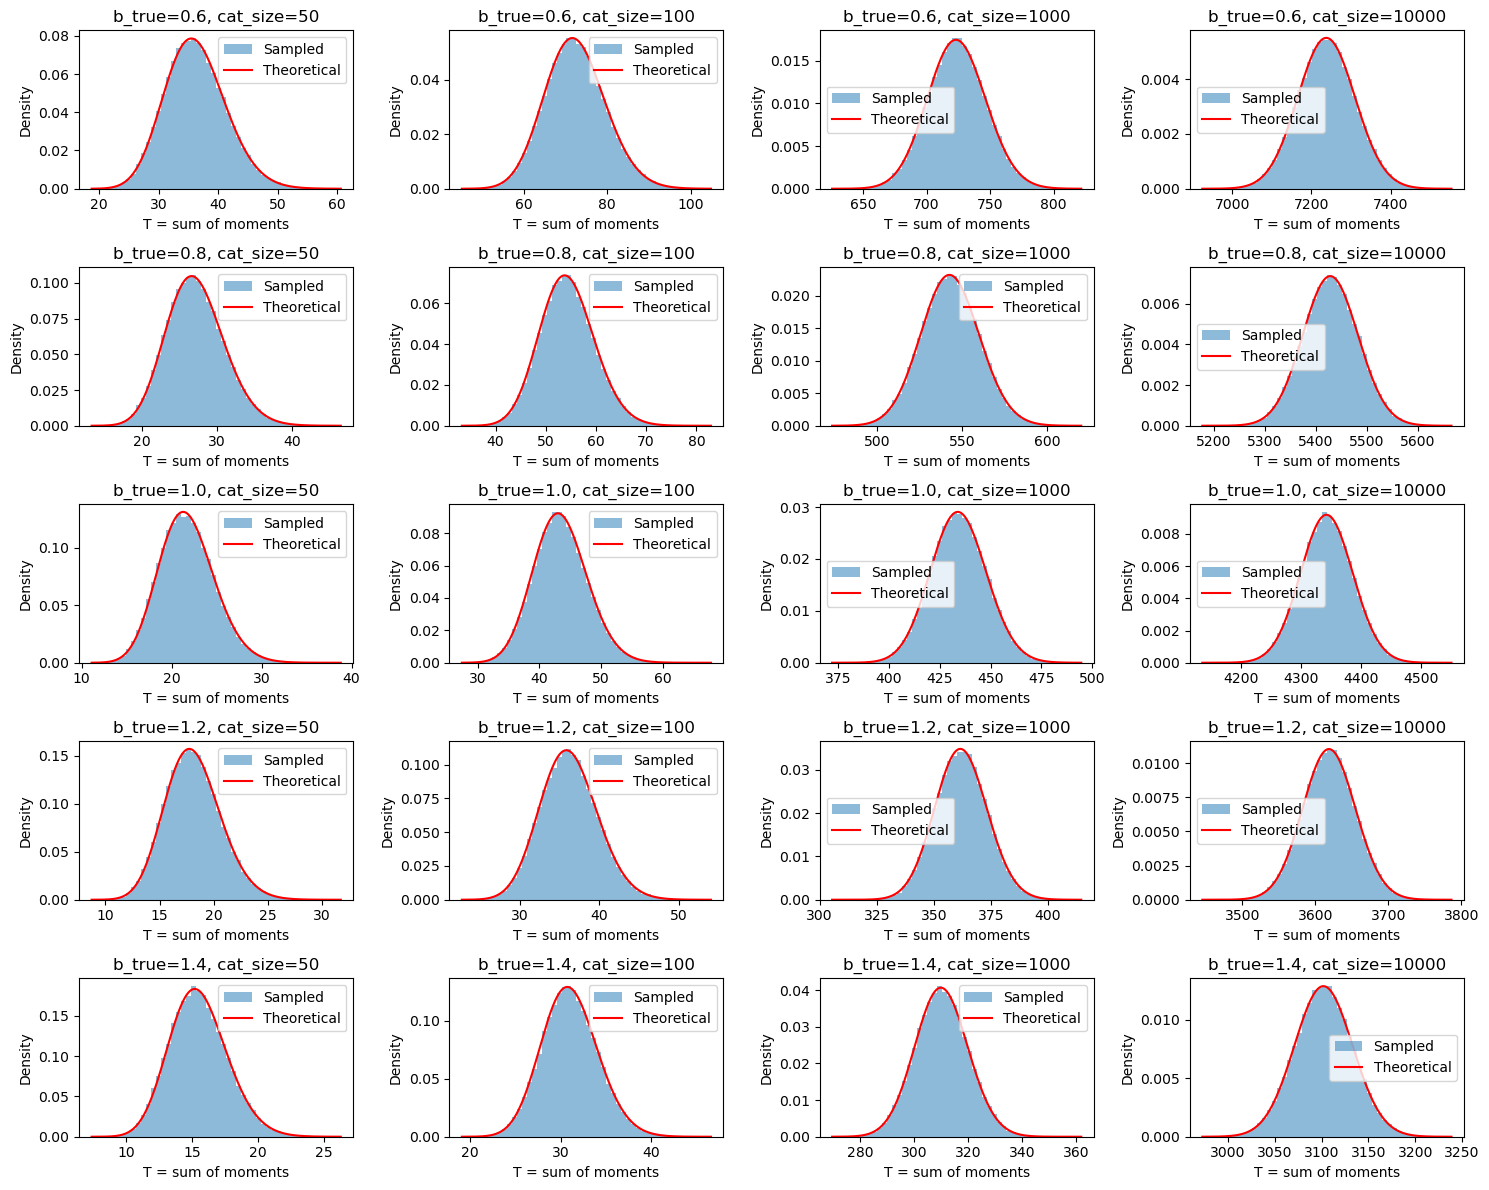

In [3]:
fig,axs = plt.subplots(nrows=len(b_true_range), ncols=len(cat_sizes), figsize=(15, 12))
for i, b_true in enumerate(b_true_range):
        for j, n in enumerate(cat_sizes):
            t_sampled = t_all[i,j,:]
            x_range = np.linspace(np.min(t_sampled), np.max(t_sampled), 1000)
            t_theory = gamma_dist(a=n, scale=1/(np.log(10)*b_true)).pdf(x_range)
            ax = axs[i,j]
            ax.hist(t_sampled, bins=50, density=True, alpha=0.5, label="Sampled")
            ax.plot(x_range, t_theory, 'r-', label="Theoretical")
            ax.set_title(f"b_true={b_true}, cat_size={n}")
            ax.set_xlabel("T = sum of moments")
            ax.set_ylabel("Density")
            ax.legend()
plt.tight_layout()
plt.show()  
            

Now that that's verified, we can simulate everything we need to know about individual catalogues by directly sampling the Gamma distribution 

Text(0.5, 1.0, 'Mean behaviour of different earthquake size predictive distributions\nBased on catalogues of size n=100')

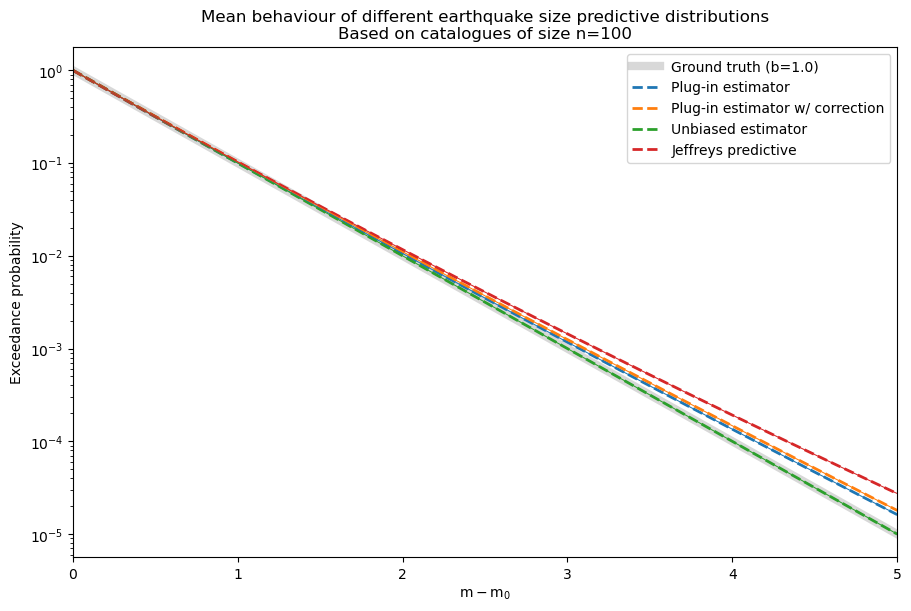

In [4]:
n=100
b_true=1.0
nr_simulations = 1_000_000

mrange = np.arange(mag_completeness, 5.01, 0.01)
mom_range = seismic_moment(mrange)
ground_truth_distribution = pareto((2/3)*b_true, scale=seismic_moment(mag_completeness), loc=0)
ground_truth_poe = ground_truth_distribution.sf(mom_range)

# Sample T from Gamma distribution (we now know this is identical to sampling catalogues and summing)
t = gamma_dist(a=n, scale=1/(np.log(10)*b_true)).rvs(nr_simulations)

# Calculate different estimators
unbiased_poe = (1-mrange[:,None]/t)**(n-1)
naive_poe = np.exp(-n*mrange[:,None]/t)
corrected_naive_poe = np.exp(-(n-1)*mrange[:,None]/t)
jeffreys_poe = (t/(t + mrange[:,None]))**n
unbiased_poe_mean = unbiased_poe.mean(axis=1)
naive_poe_mean = naive_poe.mean(axis=1)
corrected_naive_poe_mean = corrected_naive_poe.mean(axis=1)
jeffreys_poe_mean = jeffreys_poe.mean(axis=1)

# # Create figure of ground truth and different estimators (based on sampling T, i.e. based on sampling catalogues)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6), constrained_layout=True)
plot_distr(mrange, ground_truth_poe, ax=ax, label=f"Ground truth (b={b_true:.1f})", c="grey", lw=6.0,  ls="-", alpha=0.3)
plot_distr(mrange, naive_poe_mean, ax=ax, label="Plug-in estimator", c="C0", lw=2.0, ls="--")
plot_distr(mrange, corrected_naive_poe_mean, ax=ax, label="Plug-in estimator w/ correction", c="C1", lw=2.0, ls="--")
plot_distr(mrange, unbiased_poe_mean, ax=ax, label="Unbiased estimator", c="C2", lw=2.0, ls="--")
plot_distr(mrange, jeffreys_poe_mean, ax=ax, label="Jeffreys predictive", c="C3", lw=2.0, ls="--")

# Get theoretical curves for the estimators
theoretical_curves = E_all(n, b_true*np.log(10), mrange)
plot_distr(mrange, theoretical_curves['naive'], ax=ax, c="C0", lw=0.75, ls="-")
plot_distr(mrange, theoretical_curves['corrected'], ax=ax, c="C1", lw=0.75, ls="-")
plot_distr(mrange, theoretical_curves['unbiased'], ax=ax, c="C2", lw=0.75, ls="-")
plot_distr(mrange, theoretical_curves['jeffreys'], ax=ax, c="C3", lw=0.75, ls="-")

ax.set_xlim(mrange[0], mrange[-1])
# ax.set_ylim(0.8e0, 1e1)
ax.set_xlabel("$\\mathrm{m}-\\mathrm{m_0}$")
# ax.set_ylabel("$\\frac{F}{F^{true}}$", fontsize=16)
ax.set_ylabel("Exceedance probability")
ax.legend(loc="upper right")
ax.set_title(f"Mean behaviour of different earthquake size predictive distributions\n"
f"Based on catalogues of size n={n}")

Text(0.5, 0.98, 'Catalogues of size n=1000\n$\\Lambda^{true}=0.1,  q=10^{-4}$')

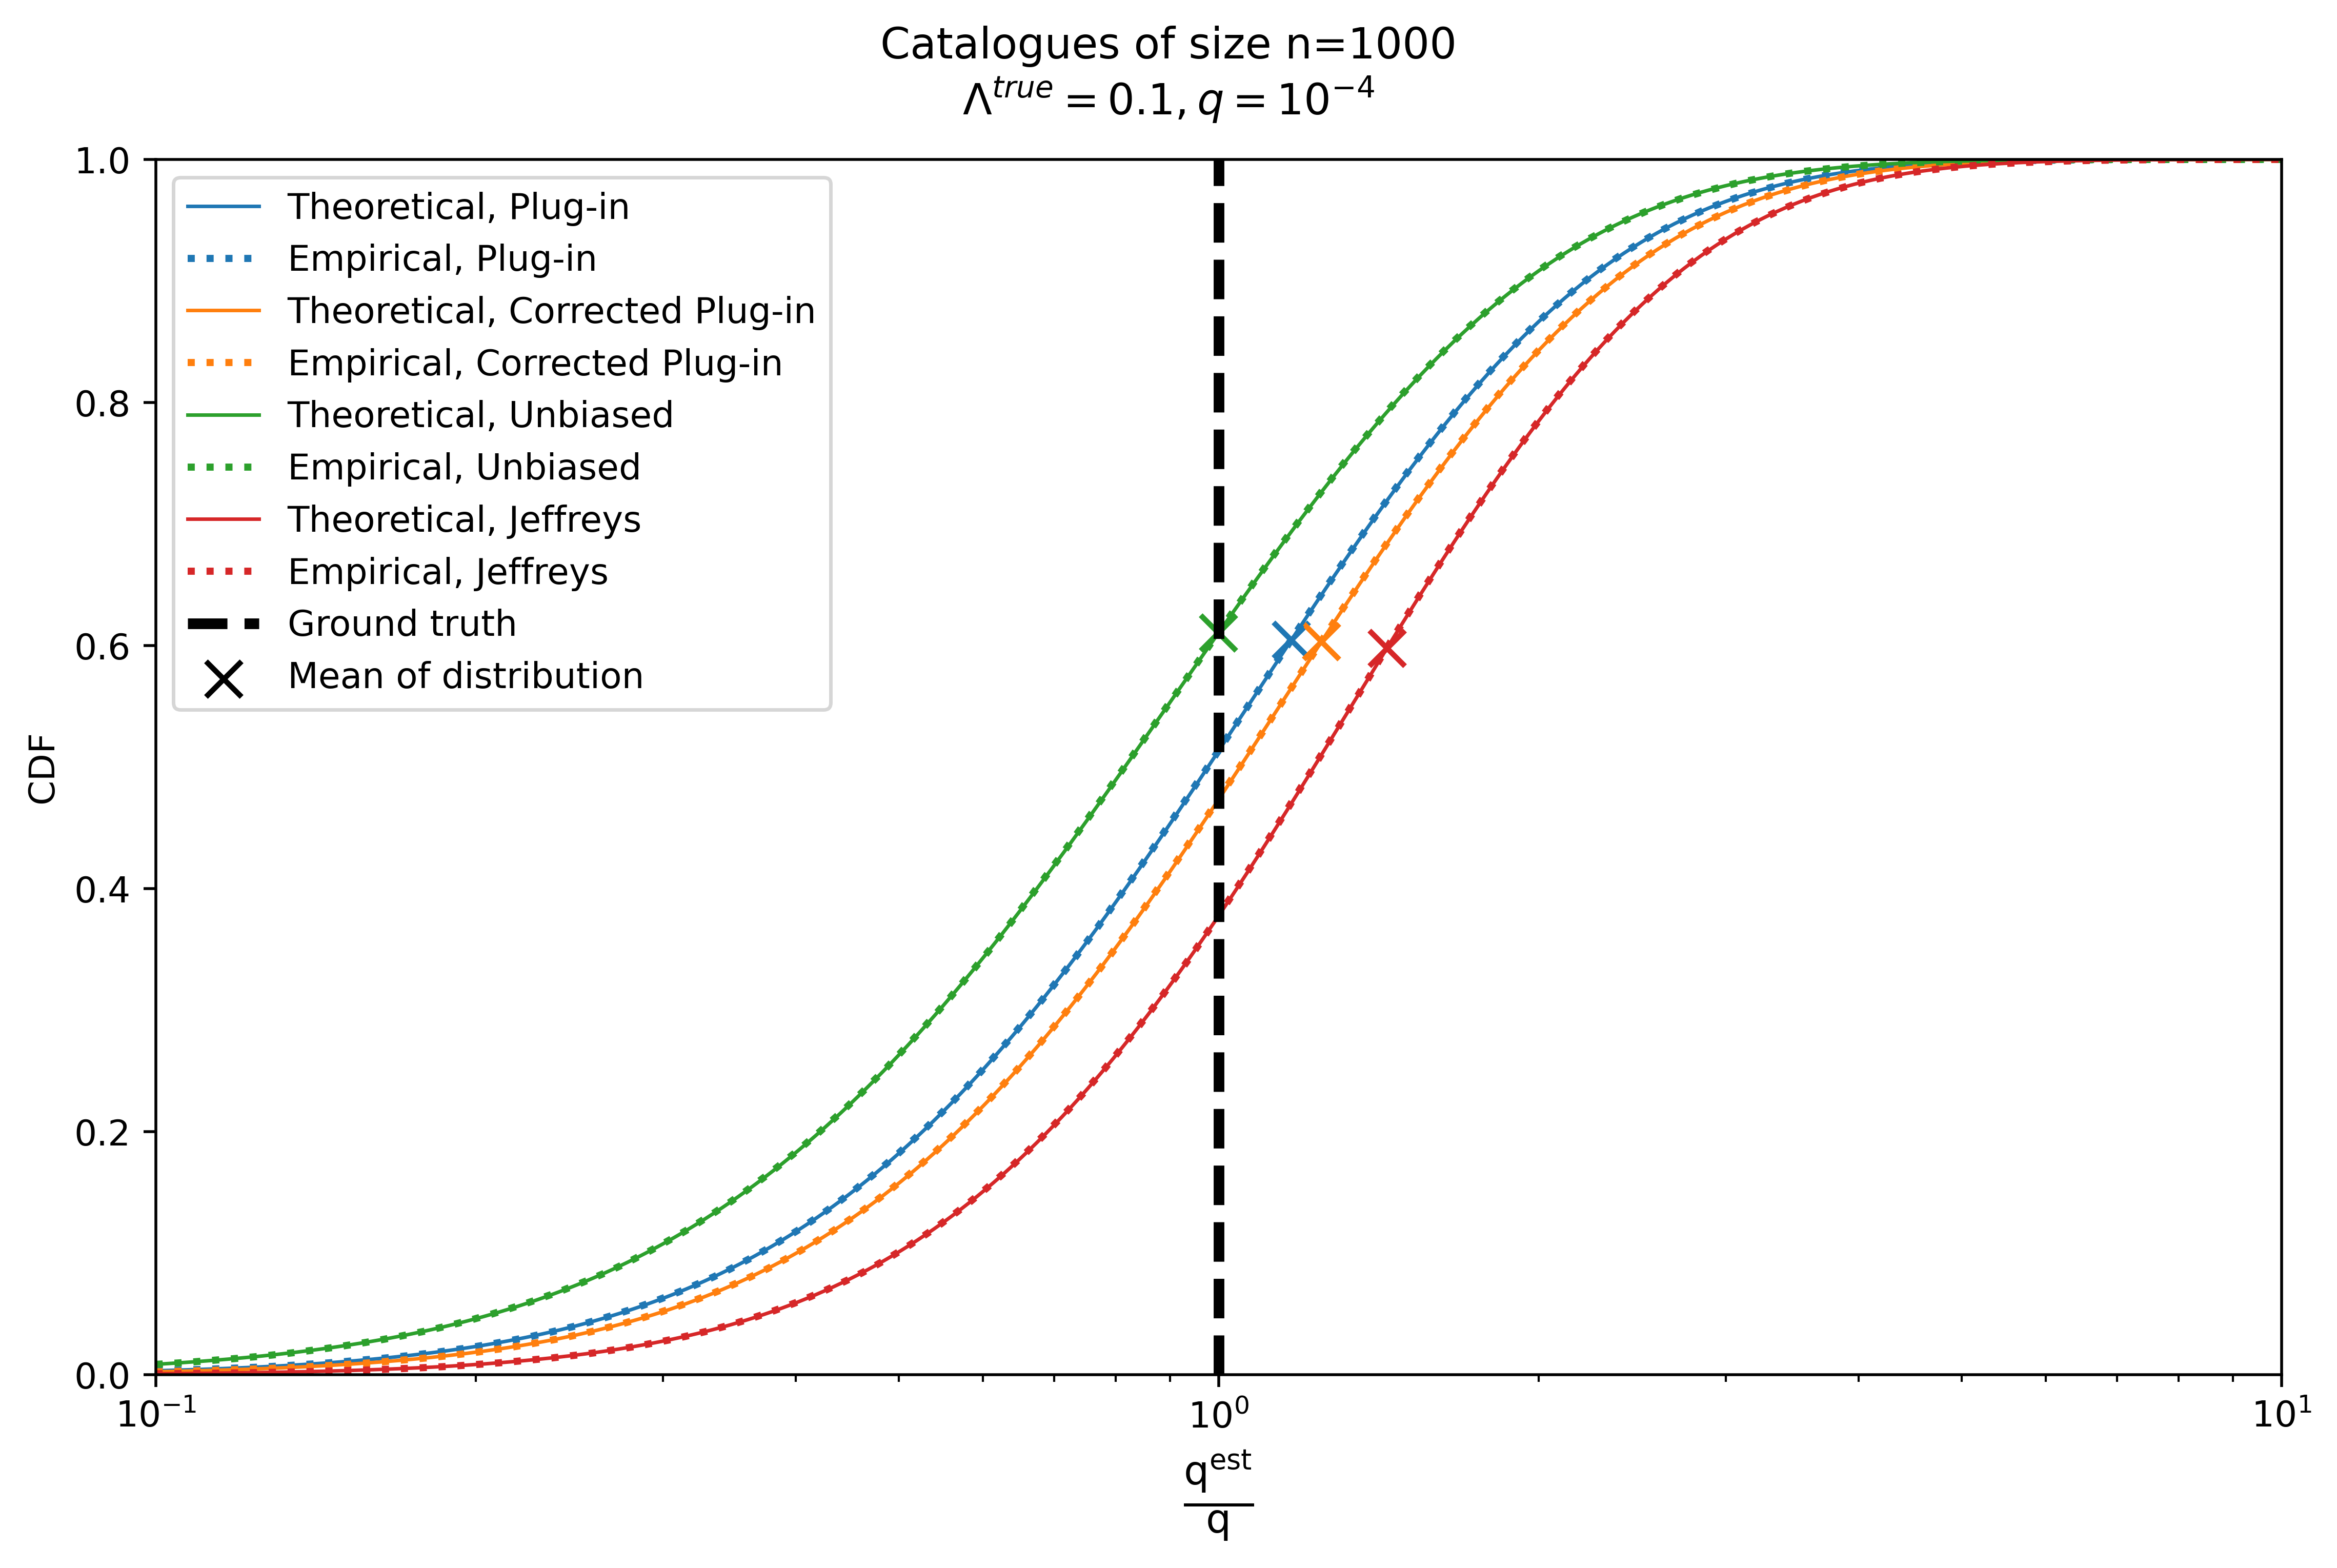

In [5]:
# How good are we at estimating the PoE of an event with true PoE 1, 0.1, 0.01 per catalogue?
catalogue_poe = 0.1 # On a catalogue basis. So 0.1 means once every 10 catalogues, or once every 10x the time period of the catalogue

q_true = catalogue_poe/n
theta = -n*np.log(q_true)
y_vals = np.logspace(-8, 0, 1000)
y_vals = y_vals[:-1]
m = -np.log10(q_true)/b_true_range[2] + mag_completeness
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6), constrained_layout=True, dpi=500)
ax=[ax]
# Naive estimator
f = pdf_naive(y_vals, n, q_true)
analytic_cdf = cdf_naive(y_vals, n, q_true)
bottom = np.interp(1e-3, analytic_cdf, y_vals )/q_true
top = np.interp(1.0-1e-3, analytic_cdf, y_vals)/q_true
bins = np.logspace(np.log10(bottom), np.log10(top), 100)
est_poes_at_m = np.exp(-n*m/t)
sorted_q = np.sort(est_poes_at_m/q_true)
ecdf = np.arange(1, len(sorted_q)+1) / len(sorted_q)
mean = np.interp(m, mrange, naive_poe_mean)
ax[0].plot(y_vals/q_true, analytic_cdf, label=f"Theoretical, Plug-in", color='C0', lw=1.0)
ax[0].plot(sorted_q, ecdf, label=f"Empirical, Plug-in",lw=2, ls=':', color='C0')
ax[0].scatter([mean/q_true], [np.interp(mean/q_true, sorted_q, ecdf)], color='C0', marker='x', s=100)



analytic_cdf = cdf_corr_naive(y_vals, n, q_true)
bottom = np.interp(1e-3, analytic_cdf, y_vals )/q_true
top = np.interp(1.0-1e-3, analytic_cdf, y_vals)/q_true
bins = np.logspace(np.log10(bottom), np.log10(top), 100)
est_poes_at_m = np.exp(-(n-1)*m/t)
sorted_q = np.sort(est_poes_at_m/q_true)
ecdf = np.arange(1, len(sorted_q)+1) / len(sorted_q)
mean = np.interp(m, mrange, corrected_naive_poe_mean)
ax[0].plot(y_vals/q_true, analytic_cdf, label=f"Theoretical, Corrected Plug-in", color='C1', lw=1.0)
ax[0].plot(sorted_q, ecdf, label=f"Empirical, Corrected Plug-in",lw=2, ls=':', color='C1')
ax[0].scatter([mean/q_true], [np.interp(mean/q_true, sorted_q, ecdf)], color='C1', marker='x', s=100)


# Unbiased estimator
f = pdf_unbiased(y_vals, n, q_true)
analytic_cdf = cdf_unbiased(y_vals, n, q_true)
bottom = np.interp(1e-3, analytic_cdf, y_vals )/q_true
top = np.interp(1.0-1e-3, analytic_cdf, y_vals)/q_true
bins = np.logspace(np.log10(bottom), np.log10(top), 100)
est_poes_at_m = (1 - m/t)**(n-1)
sorted_q = np.sort(est_poes_at_m/q_true)
ecdf = np.arange(1, len(sorted_q)+1) / len(sorted_q)
mean = np.interp(m, mrange, unbiased_poe_mean)
ax[0].plot(y_vals/q_true, analytic_cdf, label=f"Theoretical, Unbiased", color='C2', lw=1.0)
ax[0].plot(sorted_q, ecdf, label=f"Empirical, Unbiased",lw=2, ls=':', color='C2')
ax[0].scatter([mean/q_true], [np.interp(mean/q_true, sorted_q, ecdf)], color='C2', marker='x', s=100)

# Jeffeys estimator
f = pdf_jeffreys(y_vals, n, q_true)
analytic_cdf = cdf_jeffreys(y_vals, n, q_true)
bottom = np.interp(1e-3, analytic_cdf, y_vals )/q_true
top = np.interp(1.0-1e-3, analytic_cdf, y_vals)/q_true
bins = np.logspace(np.log10(bottom), np.log10(top), 100)
est_poes_at_m = (t/(t+m-mag_completeness))**n
sorted_q = np.sort(est_poes_at_m/q_true)
ecdf = np.arange(1, len(sorted_q)+1) / len(sorted_q)
mean = np.interp(m, mrange, jeffreys_poe_mean)

ax[0].plot(y_vals/q_true, analytic_cdf, label=f"Theoretical, Jeffreys", color='C3', lw=1.0)
ax[0].plot(sorted_q, ecdf, label=f"Empirical, Jeffreys",lw=2, ls=':', color='C3')
ax[0].scatter([mean/q_true], [np.interp(mean/q_true, sorted_q, ecdf)], color='C3', marker='x', s=100)
    


ax[0].set_xlabel("$\\frac{\\mathrm{q^{est}}}{\\mathrm{q}}$", fontsize=16)
ax[0].set_ylabel("CDF")
ax[0].set_xscale("log")
ax[0].set_xlim(1e-1,1e1)
ax[0].set_ylim(0,1)

ax[0].vlines(1,0, 1, colors="k", lw=3, ls="--", label="Ground truth")
ax[0].scatter([-1], [-1], color='k', marker='x', s=100, label='Mean of distribution')
ax[0].legend(loc="upper left") 
plt.suptitle(f"Catalogue true PoE={catalogue_poe}\n q={q_true:.0e}, Catalogue size={n}")
plt.suptitle('Catalogues of size n=1000'+'\n$\\Lambda^{true}=0.1,  q=10^{-4}$')


In [6]:
# Let's investigate the variance of the estimators. First we'll use the catalogue simulations done above
unbiased_var = np.var(unbiased_poe, axis=1)
naive_var = np.var(naive_poe, axis=1)
corrected_naive_var = np.var(corrected_naive_poe, axis=1)
jeffreys_var = np.var(jeffreys_poe, axis=1)


Text(0.5, 0.98, 'Properties of different earthquake size predictive distributions\nBased on catalogues of size n=100')

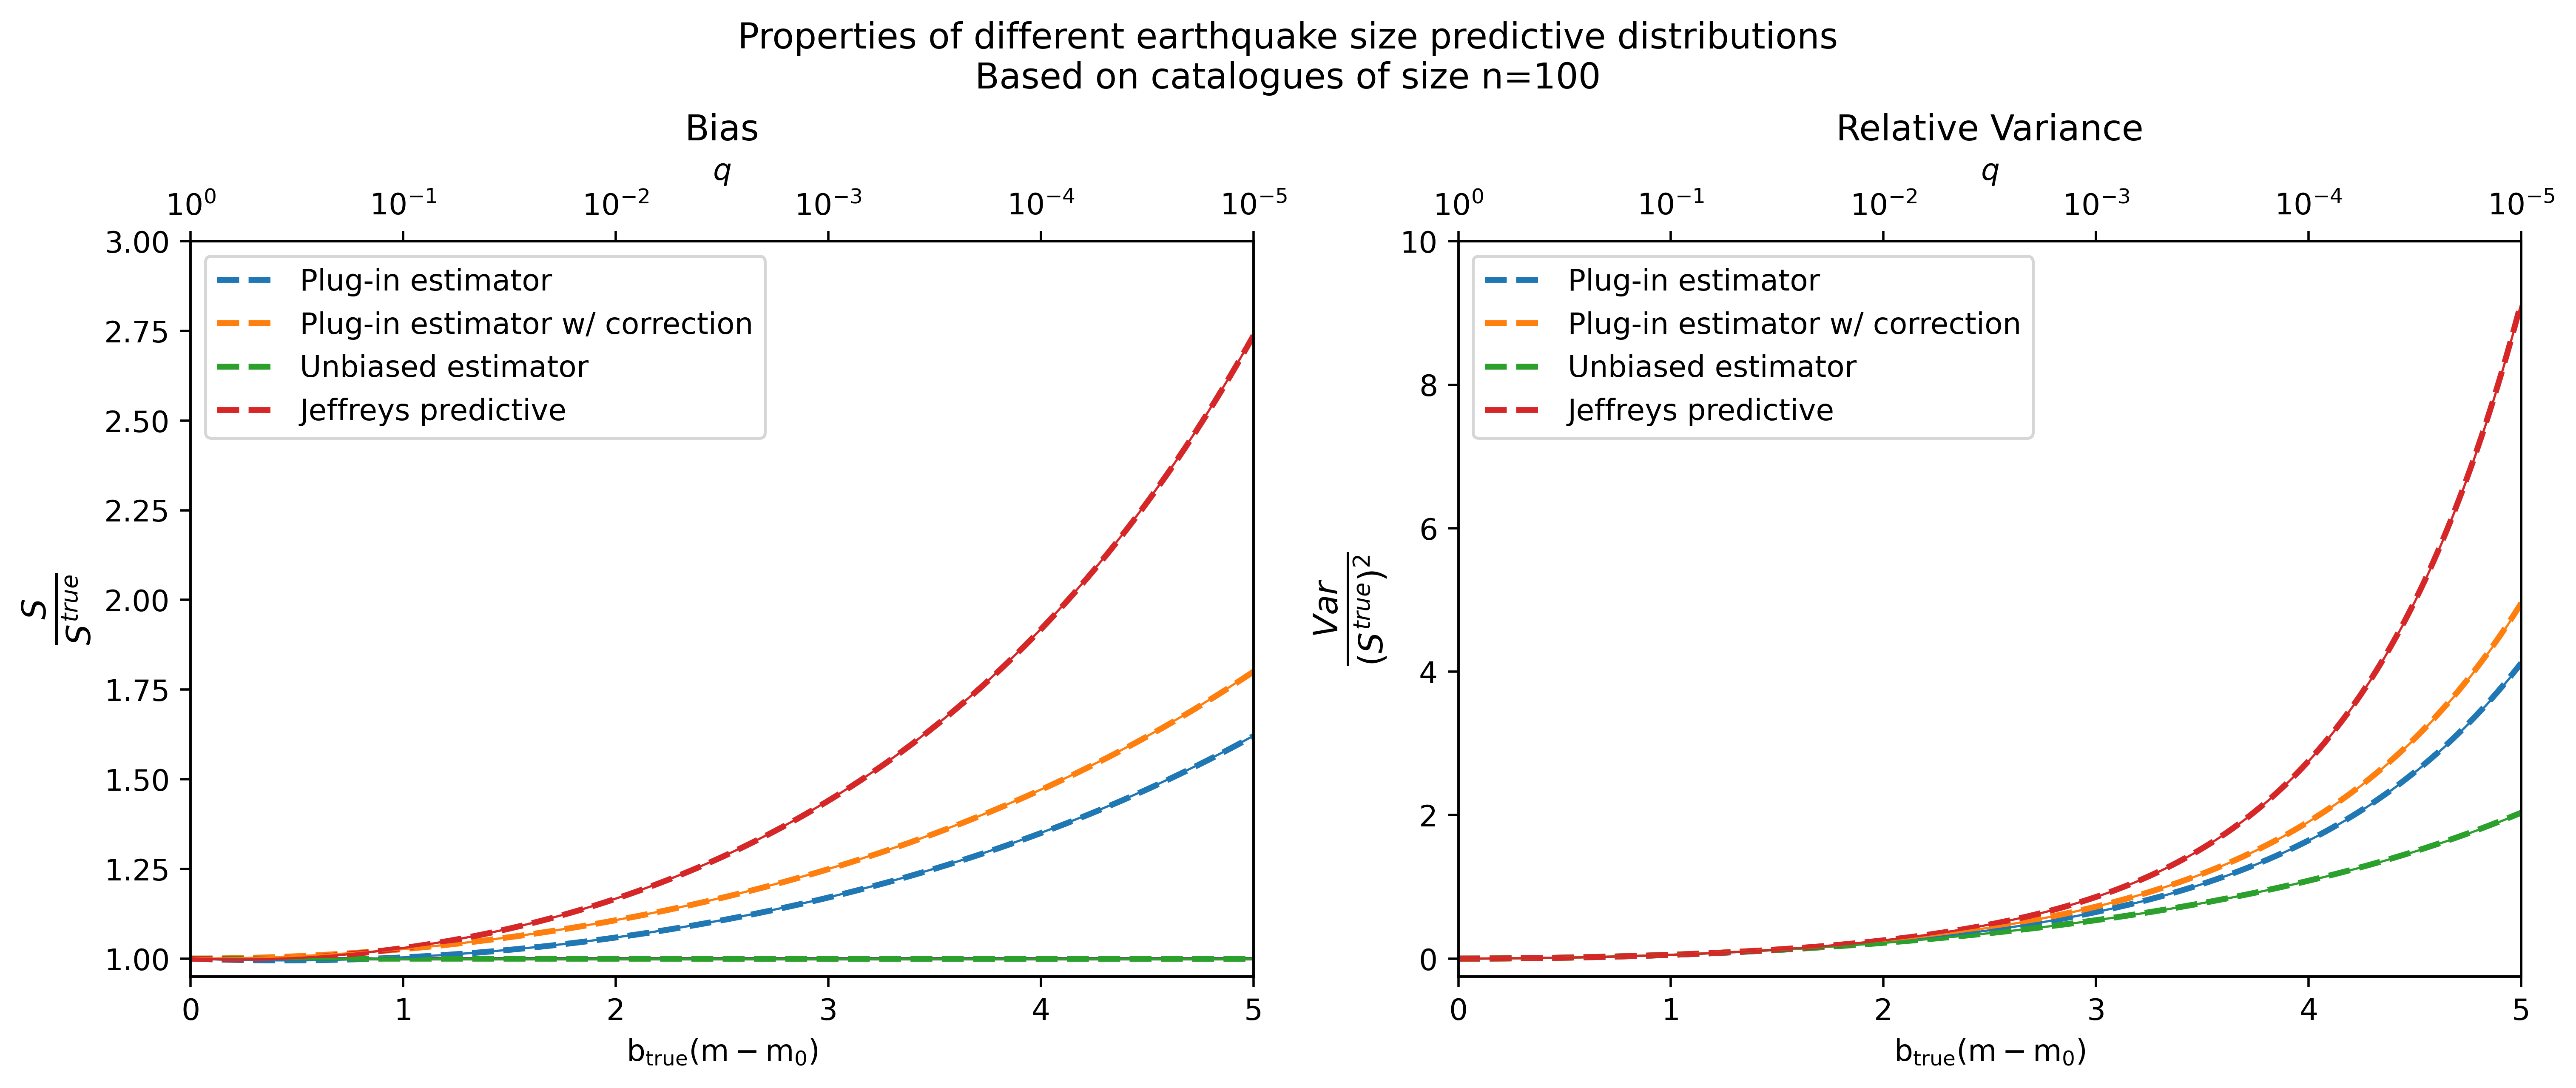

In [7]:
# Now we plot them against the magnitude
# We normalize the variance by the expected value squared to get a relative variance

# Create figure of ground truth and different estimators (based on sampling T, i.e. based on sampling catalogues)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5), constrained_layout=True, dpi=500)
ax[0].plot(mrange, ground_truth_poe/ground_truth_poe, c="k", lw=1.0, ls="-")
ax[0].plot(mrange, naive_poe_mean/ground_truth_poe, label="Plug-in estimator", c="C0", lw=2.0, ls="--")
ax[0].plot(mrange, corrected_naive_poe_mean/ground_truth_poe, label="Plug-in estimator w/ correction", c="C1", lw=2.0, ls="--")
ax[0].plot(mrange, unbiased_poe_mean/ground_truth_poe, label="Unbiased estimator", c="C2", lw=2.0, ls="--")
ax[0].plot(mrange, jeffreys_poe_mean/ground_truth_poe, label="Jeffreys predictive", c="C3", lw=2.0, ls="--")
ax[0].plot(mrange, theoretical_curves['naive']/ground_truth_poe, c="C0", lw=0.75, ls="-")
ax[0].plot(mrange, theoretical_curves['corrected']/ground_truth_poe, c="C1", lw=0.75, ls="-")
ax[0].plot(mrange, theoretical_curves['unbiased']/ground_truth_poe, c="C2", lw=0.75, ls="-")
ax[0].plot(mrange, theoretical_curves['jeffreys']/ground_truth_poe, c="C3", lw=0.75, ls="-")
# ax[0].set_yscale("log")
ax[0].set_xlim(mrange[0], mrange[-1])
ax[0].set_ylim(0.95, 3)
ax[0].set_xlabel("$\\mathrm{b_{true}(m-m_0)}$")
ax[0].set_ylabel("$\\frac{S}{S^{true}}$",fontsize=16)
ax[0].legend(loc="upper left")
ax[0].set_title(f"Bias")

ax[1].plot(mrange, naive_var/(ground_truth_poe**2), label="Plug-in estimator", c="C0", lw=2.0, ls="--")
ax[1].plot(mrange, corrected_naive_var/(ground_truth_poe**2), label="Plug-in estimator w/ correction", c="C1", lw=2.0, ls="--")
ax[1].plot(mrange, unbiased_var/(ground_truth_poe**2), label="Unbiased estimator", c="C2", lw=2.0, ls="--")
ax[1].plot(mrange, jeffreys_var/(ground_truth_poe**2), label="Jeffreys predictive", c="C3", lw=2.0, ls="--")  

# Compare to theoretical curves
theoretical_naive_var = get_var_naive(mrange, n, b_true*np.log(10))
theoretical_corrected_naive_var = get_var_corrected_naive(mrange, n, b_true*np.log(10))
theoretical_jeffreys_var = get_var_jeffreys(mrange, n, b_true*np.log(10))
theoretical_unbiased_var = get_var_unbiased(mrange, n, b_true*np.log(10))
ax[1].plot(mrange, theoretical_naive_var/(ground_truth_poe**2), c="C0", lw=0.75, ls="-")
ax[1].plot(mrange, theoretical_corrected_naive_var/(ground_truth_poe**2), c="C1", lw=0.75, ls="-")
ax[1].plot(mrange, theoretical_unbiased_var/(ground_truth_poe**2), c="C2", lw=0.75, ls="-")
ax[1].plot(mrange, theoretical_jeffreys_var/(ground_truth_poe**2), c="C3", lw=0.75, ls="-")

ax[1].set_xlim(mrange[0], mrange[-1])
ax[1].set_ylim(-0.25, 10)
ax[1].set_xlabel("$\\mathrm{b_{true}(m-m_0)}$")
ax[1].set_ylabel("$\\frac{Var}{(S^{true})^2}$",fontsize=16)


ax[1].legend(loc="upper left")
ax[1].set_title(f"Relative Variance")

# Insert a secondary x-axis using log scale for both subplots
ax0 = ax[0].twiny()
ax0.set_xlabel("$q$")
ax0.set_xticks([0,1,2,3,4,5])
ax0.set_xticklabels([f'$\\mathrm{{10^{{{x}}}}}$' for x in [0,-1,-2,-3,-4,-5]])
ax1 = ax[1].twiny()
ax1.set_xlabel("$q$")
ax1.set_xticks([0,1,2,3,4,5])
ax1.set_xticklabels([f'$\\mathrm{{10^{{{x}}}}}$' for x in [0,-1,-2,-3,-4,-5]])




plt.suptitle(f"Properties of different earthquake size predictive distributions\n"
f"Based on catalogues of size n={n}")#   +", $b^*_{true}=\\mathrm{ln}(10)$")

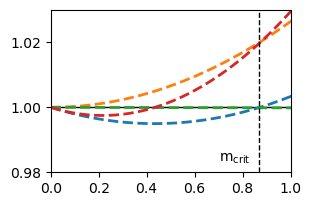

In [8]:
# Bias ratio plots: Mean of estimator divided by ground truth PoE
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 2), constrained_layout=True)
ax.plot(mrange, ground_truth_poe/ground_truth_poe, c="k", lw=1.0, ls="-")
ax.plot(mrange, naive_poe_mean/ground_truth_poe, label="Naive estimator", c="C0", lw=2.0, ls="--")
ax.plot(mrange, corrected_naive_poe_mean/ground_truth_poe, label="Naive estimator w/ correction", c="C1", lw=2.0, ls="--")
ax.plot(mrange, unbiased_poe_mean/ground_truth_poe, label="Unbiased estimator", c="C2", lw=2.0, ls="--")
ax.plot(mrange, jeffreys_poe_mean/ground_truth_poe, label="Jeffreys estimator", c="C3", lw=2.0, ls="--")
ax.vlines(0.87,0.98,1.03, colors="k", lw=1.0, ls="--")
# Add label a vline: m_crit
ax.text(0.70, 0.982, "$\\mathrm{m_{crit}}$", verticalalignment='bottom', fontsize=10)
ax.set_xlim(mrange[0], 1)
ax.set_ylim(0.98, 1.03)
# ax.set_yscale("log")
plt.show()

In [9]:
l_true_range = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
n_range = np.array([100, 1000, 10000, 100000])

var_funcs = {
    "naive": cdf_naive,
    "unbiased": cdf_unbiased,
    "jeffreys": cdf_jeffreys,
    "corrected": cdf_corr_naive,
}

for lambda_true in l_true_range:
    for n_loop in n_range:
        q = lambda_true / n_loop
        
        # Compute variances for all functions
        variances = {name: mean_var_from_cdf(cdf_func, n_loop, q)[1]
                     for name, cdf_func in var_funcs.items()}
        
        # Sort by variance (ascending)
        ranked = sorted(variances.items(), key=lambda x: x[1])
        
        # Prepare a readable ranking string
        ranking_str = ", ".join([f"{i+1}st={name}" if i == 0 else
                                 f"{i+1}nd={name}" if i == 1 else
                                 f"{i+1}rd={name}" if i == 2 else
                                 f"{i+1}th={name}"
                                 for i, (name, _) in enumerate(ranked)])
        
        print(f"lambda_true={lambda_true:.3e} \t n={n_loop:.2e} \t => Ranking: {ranking_str}")

lambda_true=1.000e-05 	 n=1.00e+02 	 => Ranking: 1st=unbiased, 2nd=naive, 3rd=corrected, 4th=jeffreys
lambda_true=1.000e-05 	 n=1.00e+03 	 => Ranking: 1st=unbiased, 2nd=naive, 3rd=corrected, 4th=jeffreys
lambda_true=1.000e-05 	 n=1.00e+04 	 => Ranking: 1st=unbiased, 2nd=naive, 3rd=corrected, 4th=jeffreys
lambda_true=1.000e-05 	 n=1.00e+05 	 => Ranking: 1st=unbiased, 2nd=naive, 3rd=corrected, 4th=jeffreys
lambda_true=1.000e-04 	 n=1.00e+02 	 => Ranking: 1st=unbiased, 2nd=naive, 3rd=corrected, 4th=jeffreys
lambda_true=1.000e-04 	 n=1.00e+03 	 => Ranking: 1st=unbiased, 2nd=naive, 3rd=corrected, 4th=jeffreys
lambda_true=1.000e-04 	 n=1.00e+04 	 => Ranking: 1st=unbiased, 2nd=naive, 3rd=corrected, 4th=jeffreys
lambda_true=1.000e-04 	 n=1.00e+05 	 => Ranking: 1st=unbiased, 2nd=naive, 3rd=corrected, 4th=jeffreys
lambda_true=1.000e-03 	 n=1.00e+02 	 => Ranking: 1st=unbiased, 2nd=naive, 3rd=corrected, 4th=jeffreys
lambda_true=1.000e-03 	 n=1.00e+03 	 => Ranking: 1st=unbiased, 2nd=naive, 3rd=corr

In [10]:
# For table in the paper
n = 100
catalogue_poe = 0.1
q_true = catalogue_poe/n

print(f'q_true={q_true} (cat size={n}, catalogue PoE={catalogue_poe})')
print("Naive summary:", summary_naive(q_true, n))
print("Corrected naive summary:", summary_corrected_naive(q_true, n))
print("Unbiased summary:", summary_unbiased(q_true, n))
print("Jeffreys summary:", summary_jeffreys(q_true, n))

q_true=0.001 (cat size=100, catalogue PoE=0.1)
Naive summary: {'mean': 0.0011706855382120635, 'var': 6.489039429215337e-07, 'p2.5': 0.00020552527801350132, 'p50': 0.0009771754390427159, 'p97.5': 0.0032431824715125064}
Corrected naive summary: {'mean': 0.0012498492883127013, 'var': 7.238270529260732e-07, 'p2.5': 0.00022373637221035215, 'p50': 0.0010473041324496747, 'p97.5': 0.0034344853663471554}
Unbiased summary: {'mean': 0.0010000000000000015, 'var': 5.352369183185499e-07, 'p2.5': 0.00015325492998881273, 'p50': 0.0008161530603810093, 'p97.5': 0.002900212433234453}
Jeffreys summary: {'mean': 0.0014406487598481467, 'var': 8.589312118833234e-07, 'p2.5': 0.00028910292686821267, 'p50': 0.0012294203185994812, 'p97.5': 0.0037991268595520085}


/home/osingas/git/earthquake-size-estimation/funcs.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  s0 = L / (1.0 - u)


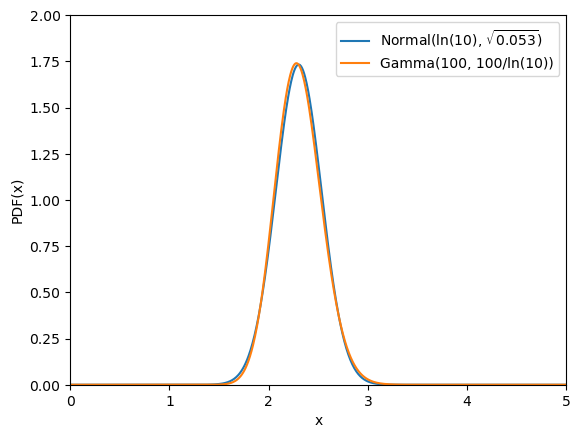

In [11]:
# Show similarity of normal and gamma distributions for these parameters
beta_mean = np.log(10)
beta_sd = 0.230259
x = np.linspace(0,5,1000)
alpha = 100
lamb = alpha / beta_mean

plt.plot(x, norm_pdf(x,beta_mean, beta_sd), label="Normal(ln(10), $\sqrt{0.053}$)")
plt.plot(x, gamma_pdf(x, alpha, lamb), label="Gamma(100, 100/ln(10))")
plt.xlabel("x")
plt.ylabel("PDF(x)")
plt.xlim(0,5)
plt.ylim(0,2)
plt.legend()